In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Original dataset

In [4]:
# from src.dataset.shape_cor import PairFaustDataset

# dataset = PairFaustDataset(
#     phase='train',
#     data_root='../../data/FAUST_r/',
#     return_evecs='true',
#     return_faces='true',
#     num_evecs=200,
#     return_corr='false',
#     return_dist='false',
# )

In [5]:
# import time
# start_time = time.time()

# for idx, data in enumerate(dataset):
#     if idx >= 10:
#         break

# end_time = time.time()
# sample_per_sec = 10 / (end_time - start_time)
# eta = len(dataset) / sample_per_sec / 60
# print(f"total: {10 / (sample_per_sec)} sample/s | eta: {eta} min")
# # total: 2.158205032348633 sample/s | eta: 23.020853678385414 min

## Fast dataset

In [6]:
from src.dataset.shape_cor_fast import PairFaustDatasetFast

dataset = PairFaustDatasetFast(
    data_root='../../data_/FAUST_r',
    phase='train',
    return_faces=True,
    return_L=True,
    return_mass=True,
    num_evecs=200,
    return_evecs=True,
    return_grad=True,
    return_corr=True,
    return_dist=True,
)
len(dataset)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


6400

In [7]:
from tqdm import tqdm

for data in tqdm(dataset):
    # pass
    break

  0%|          | 0/6400 [00:00<?, ?it/s]


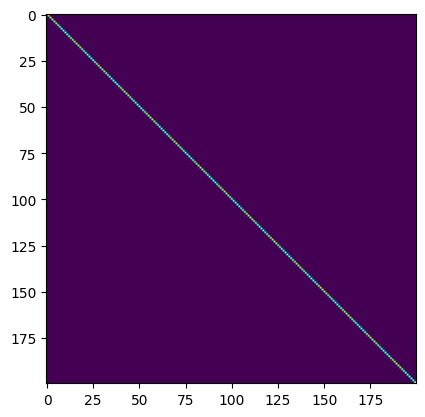

In [8]:
import matplotlib.pyplot as plt
plt.imshow(data['first']['evecs_trans'] @ data['first']['evecs'])
plt.show()

## Batched dataloader

In [9]:
from tqdm import tqdm
from src.utils.tensor import to_device
from src.dataloader.shape_cor_batch import BatchShapePairDataLoader

batch_loader = BatchShapePairDataLoader(
    dataset=dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
)

for batch in tqdm(batch_loader, total=len(batch_loader)):
    # pass
    batch = to_device(batch, device)
    break

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:05<?, ?it/s]


In [10]:
batch['first']['num_verts'][0], batch['first']['verts'][0][4999:, :]

(5001,
 tensor([[ 0.0115, -0.5356, -0.1038],
         [ 0.0061, -0.5331, -0.1032]], device='cuda:0'))

## Point descriptors

In [11]:
batch['first']['evecs_trans'].shape

torch.Size([8, 200, 5001])

In [12]:
def get_single(batch, idx, name='first'):
    num_verts = batch[name]['num_verts'][idx]
    return {
        'evals': batch[name]['evals'][idx].unsqueeze(0),
        'evecs': batch[name]['evecs'][idx][0:num_verts].unsqueeze(0),
        'evecs_trans': batch[name]['evecs_trans'][idx][:, 0:num_verts].unsqueeze(0),
        'mass': batch[name]['mass'][idx][0:num_verts].unsqueeze(0),
        'verts': batch[name]['verts'][idx][0:num_verts].unsqueeze(0),
        'faces': batch[name]['faces'][idx][0:num_verts].unsqueeze(0),
        'gradX': torch.sparse_coo_tensor(
            batch[name]['gradX_indices'],
            batch[name]['gradX_values'],
            batch[name]['gradX_size'],
        ).to_dense()[idx, :num_verts, :num_verts].unsqueeze(0).to_sparse_coo(),
        'gradY': torch.sparse_coo_tensor(
            batch[name]['gradY_indices'],
            batch[name]['gradY_values'],
            batch[name]['gradY_size'],
        ).to_dense()[idx, :num_verts, :num_verts].unsqueeze(0).to_sparse_coo(),
    }

### HKS

In [13]:
batch['first']['evals'][0].shape, batch['first']['evecs'][0].shape

(torch.Size([200]), torch.Size([5001, 200]))

In [14]:
from src.utils.geometry import compute_hks_autoscale
from tqdm import tqdm

for _ in tqdm(range(10)):
    hks_batch = compute_hks_autoscale(
        batch['first']['evals'],
        batch['first']['evecs'],
    )

hks_batch.shape

100%|██████████| 10/10 [00:00<00:00, 11345.16it/s]


torch.Size([8, 5001, 16])

In [15]:
# signal on the padded points
(hks_batch[0, batch['first']['num_verts'][0]:]).norm()

tensor(0., device='cuda:0')

In [16]:
# validate padded batch computation
batch_size = len(batch['first']['evals'])

for idx in range(batch_size):
    num_verts = batch['first']['num_verts'][idx]
    single = get_single(batch, idx, name='first')
    hks = compute_hks_autoscale(
        single['evals'],
        single['evecs'],
    )
    print(idx, (hks_batch[idx][:num_verts] - hks[0]).norm())

0 tensor(0., device='cuda:0')
1 tensor(0., device='cuda:0')
2 tensor(0., device='cuda:0')
3 tensor(0., device='cuda:0')
4 tensor(0., device='cuda:0')
5 tensor(0., device='cuda:0')
6 tensor(0., device='cuda:0')
7 tensor(0., device='cuda:0')


In [17]:
# validate module
from src.module.point_descriptor import HKS

hks_mod = HKS()

(hks_batch - hks_mod(
    batch['first']['evals'],
    batch['first']['evecs'],
)).norm()

tensor(0., device='cuda:0')

In [18]:
from tqdm import tqdm

for _ in tqdm(range(10)):
    hks_mod(
        batch['first']['evals'],
        batch['first']['evecs'],
    )

100%|██████████| 10/10 [00:00<00:00, 25606.25it/s]


### WKS

In [19]:
from src.utils.geometry import compute_wks_autoscale

from tqdm import tqdm

for _ in tqdm(range(10)):
    wks_batch = compute_wks_autoscale(
        batch['first']['evals'],
        batch['first']['evecs'],
        batch['first']['mass'],
    )

wks_batch.shape

100%|██████████| 10/10 [00:00<00:00, 27.09it/s]


torch.Size([8, 5001, 128])

In [20]:
# signal on the padded points
(wks_batch[0, batch['first']['num_verts'][0]:]).norm()

tensor(0., device='cuda:0')

In [21]:
# validate padded batch computation
batch_size = len(batch['first']['evals'])

for idx in range(batch_size):
    num_verts = batch['first']['num_verts'][idx]
    single = get_single(batch, idx, name='first')
    wks = compute_wks_autoscale(
        single['evals'],
        single['evecs'],
        single['mass'],
    )
    print(idx, (wks_batch[idx][:num_verts] - wks[0]).norm())

0 tensor(0., device='cuda:0')
1 tensor(0., device='cuda:0')
2 tensor(0., device='cuda:0')
3 tensor(0., device='cuda:0')
4 tensor(0., device='cuda:0')
5 tensor(0., device='cuda:0')
6 tensor(0., device='cuda:0')
7 tensor(0., device='cuda:0')


In [22]:
# validate module
from src.module.point_descriptor import WKS

wks_mod = WKS()

(wks_batch - wks_mod(
    batch['first']['evals'],
    batch['first']['evecs'],
    batch['first']['mass'],
    n_eig=128,
)).norm()

tensor(0., device='cuda:0')

In [23]:
from tqdm import tqdm

for _ in tqdm(range(10)):
    wks_mod(
        batch['first']['evals'],
        batch['first']['evecs'],
        batch['first']['mass'],
        n_eig=128,
    )

100%|██████████| 10/10 [00:00<00:00, 105.74it/s]


In [24]:
# validate module
from src.module.point_descriptor import WKS_vectorized

wks_mod = WKS_vectorized()

(wks_batch - wks_mod(
    batch['first']['evals'],
    batch['first']['evecs'],
    batch['first']['mass'],
    n_eig=128,
)).norm()

tensor(0.0009, device='cuda:0')

In [25]:
wks_batch_vec = wks_mod(
    batch['first']['evals'],
    batch['first']['evecs'],
    batch['first']['mass'],
    n_eig=128,
)

# signal on the padded points
(wks_batch_vec[0, batch['first']['num_verts'][0]:]).norm()

tensor(0., device='cuda:0')

In [26]:
from tqdm import tqdm

for _ in tqdm(range(10)):
    wks_mod(
        batch['first']['evals'],
        batch['first']['evecs'],
        batch['first']['mass'],
        n_eig=128,
    )

100%|██████████| 10/10 [00:00<00:00, 4503.71it/s]


### XYZ w/ random rotation

In [27]:
from src.utils.geometry import data_augmentation
from tqdm import tqdm

for _ in tqdm(range(10)):
    xyz_batch = data_augmentation(
        batch['first']['verts'],
    )

xyz_batch.shape

100%|██████████| 10/10 [00:00<00:00, 75.02it/s]


torch.Size([8, 5001, 3])

In [28]:
# signal on the padded points
(xyz_batch[0, batch['first']['num_verts'][0]:]).norm()

tensor(0., device='cuda:0')

In [29]:
from src.module.point_descriptor import XYZ
from tqdm import tqdm

xyz_mod = XYZ()

for _ in tqdm(range(10)):
    xyz_mod(
        batch['first']['verts'],
        batch['first']['verts_mask'],
    )

100%|██████████| 10/10 [00:00<00:00, 2212.42it/s]


In [30]:
from src.module.point_descriptor import XYZ_vectorized
from tqdm import tqdm

xyz_mod = XYZ_vectorized()

for _ in tqdm(range(10)):
    xyz_batch_vec = xyz_mod(
        batch['first']['verts'],
        batch['first']['verts_mask'],
    )

xyz_batch_vec.shape

100%|██████████| 10/10 [00:00<00:00, 3344.47it/s]


torch.Size([8, 5001, 3])

In [31]:
# signal on the padded points
(xyz_batch_vec[0, batch['first']['num_verts'][0]:]).norm()

tensor(0., device='cuda:0')

## Backbone

### DiffusionNet

In [32]:
from src.module.diffusionnet_vanilla import DiffusionNet_vanilla

feat_mod = DiffusionNet_vanilla(
    C_in=128,  # input channels
    C_out=128,  # output channels
)
feat_mod.to(device=device)
feat_mod.eval()

for _ in tqdm(range(10)):
    feat_batch = feat_mod(
        x_in=wks_batch,
        mass=batch['first']['mass'],
        evals=batch['first']['evals'],
        evecs=batch['first']['evecs'],
        gradX=torch.sparse_coo_tensor(
            batch['first']['gradX_indices'],
            batch['first']['gradX_values'],
            batch['first']['gradX_size'],
        ),
        gradY=torch.sparse_coo_tensor(
            batch['first']['gradY_indices'],
            batch['first']['gradY_values'],
            batch['first']['gradY_size'],
        ),
    )

feat_batch.shape

100%|██████████| 10/10 [00:00<00:00, 25.14it/s]


torch.Size([8, 5001, 128])

In [33]:
# signal on the padded points
(feat_batch[0, batch['first']['num_verts'][0]:]).norm()

tensor(0., device='cuda:0', grad_fn=<NormBackward1>)

In [34]:
# validate padded batch computation
batch_size = len(batch['first']['evals'])

for idx in range(batch_size):
    num_verts = batch['first']['num_verts'][idx]
    single = get_single(batch, idx, name='first')

    wks = compute_wks_autoscale(
        single['evals'],
        single['evecs'],
        single['mass'],
    )

    feat = feat_mod(
        x_in=wks,
        mass=single['mass'],
        evals=single['evals'],
        evecs=single['evecs'],
        gradX=single['gradX'],
        gradY=single['gradY'],
    )
    print(idx, (feat_batch[idx][:num_verts] - feat[0]).norm())

0 tensor(0.0012, device='cuda:0', grad_fn=<NormBackward1>)
1 tensor(0.0012, device='cuda:0', grad_fn=<NormBackward1>)
2 tensor(0.0014, device='cuda:0', grad_fn=<NormBackward1>)
3 tensor(0.0012, device='cuda:0', grad_fn=<NormBackward1>)
4 tensor(0.0013, device='cuda:0', grad_fn=<NormBackward1>)
5 tensor(0.0012, device='cuda:0', grad_fn=<NormBackward1>)
6 tensor(0.0012, device='cuda:0', grad_fn=<NormBackward1>)
7 tensor(0.0012, device='cuda:0', grad_fn=<NormBackward1>)


In [35]:
# validate vectorized module
from src.module.diffusionnet_vectorized import DiffusionNet_vectorized

feat_mod_vec = DiffusionNet_vectorized(
    C_in=128,  # input channels
    C_out=128,  # output channels
)
feat_mod_vec.load_state_dict(
    feat_mod.state_dict()
)
feat_mod_vec.to(device=device)
feat_mod_vec.eval()

for _ in tqdm(range(10)):
    feat_batch_vec = feat_mod_vec(
        x_in=wks_batch,
        mass=batch['first']['mass'],
        evals=batch['first']['evals'],
        evecs=batch['first']['evecs'],
        gradX=torch.sparse_coo_tensor(
            batch['first']['gradX_indices'],
            batch['first']['gradX_values'],
            batch['first']['gradX_size'],
        ),
        gradY=torch.sparse_coo_tensor(
            batch['first']['gradY_indices'],
            batch['first']['gradY_values'],
            batch['first']['gradY_size'],
        ),
    )

(feat_batch_vec - feat_batch).norm()

100%|██████████| 10/10 [00:00<00:00, 51.26it/s]


tensor(0., device='cuda:0', grad_fn=<NormBackward1>)

### Permutation

In [36]:
from src.module.permutation import Similarity

permute_mod = Similarity()

for _ in tqdm(range(10)):
    permute_batch = permute_mod(feat_batch_vec)

permute_batch.shape

100%|██████████| 10/10 [00:00<00:00, 13144.17it/s]


torch.Size([8, 5001, 128])

In [37]:
# signal on the padded points
(permute_batch[0, batch['first']['num_verts'][0]:]).norm()

tensor(0., device='cuda:0', grad_fn=<NormBackward1>)

In [38]:
# validate padded batch computation
batch_size = len(batch['first']['evals'])

for idx in range(batch_size):
    num_verts = batch['first']['num_verts'][idx]
    single = get_single(batch, idx, name='first')

    wks = compute_wks_autoscale(
        single['evals'],
        single['evecs'],
        single['mass'],
    )

    feat = feat_mod(
        x_in=wks,
        mass=single['mass'],
        evals=single['evals'],
        evecs=single['evecs'],
        gradX=single['gradX'],
        gradY=single['gradY'],
    )

    permute = permute_mod(feat)

    print(idx, (permute_batch[idx][:num_verts] - permute[0]).norm())

0 tensor(0.0002, device='cuda:0', grad_fn=<NormBackward1>)
1 tensor(0.0002, device='cuda:0', grad_fn=<NormBackward1>)
2 tensor(0.0002, device='cuda:0', grad_fn=<NormBackward1>)
3 tensor(0.0001, device='cuda:0', grad_fn=<NormBackward1>)
4 tensor(0.0002, device='cuda:0', grad_fn=<NormBackward1>)
5 tensor(0.0002, device='cuda:0', grad_fn=<NormBackward1>)
6 tensor(0.0002, device='cuda:0', grad_fn=<NormBackward1>)
7 tensor(0.0002, device='cuda:0', grad_fn=<NormBackward1>)


### Regularized FMaps

In [39]:
from src.module.fmap import RegularizedFMNet

fmap_mod = RegularizedFMNet()

wks_batch_vec2 = wks_mod(
    batch['second']['evals'],
    batch['second']['evecs'],
    batch['second']['mass'],
    n_eig=128,
)

feat_batch_vec2 = feat_mod_vec(
    x_in=wks_batch_vec2,
    mass=batch['second']['mass'],
    evals=batch['second']['evals'],
    evecs=batch['second']['evecs'],
    gradX=torch.sparse_coo_tensor(
        batch['second']['gradX_indices'],
        batch['second']['gradX_values'],
        batch['second']['gradX_size'],
    ),
    gradY=torch.sparse_coo_tensor(
        batch['second']['gradY_indices'],
        batch['second']['gradY_values'],
        batch['second']['gradY_size'],
    ),
)

for _ in tqdm(range(10)):
    fmap_batch = fmap_mod(
        feat_x=feat_batch_vec,
        feat_y=feat_batch_vec2,
        evals_x=batch['first']['evals'],
        evals_y=batch['second']['evals'],
        evecs_trans_x=batch['first']['evecs_trans'],
        evecs_trans_y=batch['second']['evecs_trans'],
    )[0]

fmap_batch.shape

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


torch.Size([8, 200, 200])

In [40]:
# validate padded batch computation
batch_size = len(batch['first']['evals'])

for idx in range(batch_size):
    single = get_single(batch, idx, name='first')

    wks = compute_wks_autoscale(
        single['evals'],
        single['evecs'],
        single['mass'],
    )

    feat = feat_mod(
        x_in=wks,
        mass=single['mass'],
        evals=single['evals'],
        evecs=single['evecs'],
        gradX=single['gradX'],
        gradY=single['gradY'],
    )

    single2 = get_single(batch, idx, name='second')

    wks2 = compute_wks_autoscale(
        single2['evals'],
        single2['evecs'],
        single2['mass'],
    )

    feat2 = feat_mod(
        x_in=wks2,
        mass=single2['mass'],
        evals=single2['evals'],
        evecs=single2['evecs'],
        gradX=single2['gradX'],
        gradY=single2['gradY'],
    )

    fmap = fmap_mod(
        feat_x=feat,
        feat_y=feat2,
        evals_x=single['evals'],
        evals_y=single2['evals'],
        evecs_trans_x=single['evecs_trans'],
        evecs_trans_y=single2['evecs_trans'],
    )[0]

    print(idx, (fmap_batch[idx] - fmap[0]).norm())

0 tensor(5.0142e-05, device='cuda:0', grad_fn=<NormBackward1>)
1 tensor(7.9880e-05, device='cuda:0', grad_fn=<NormBackward1>)


2 tensor(4.4248e-05, device='cuda:0', grad_fn=<NormBackward1>)
3 tensor(5.6922e-05, device='cuda:0', grad_fn=<NormBackward1>)
4 tensor(4.7105e-05, device='cuda:0', grad_fn=<NormBackward1>)
5 tensor(5.1749e-05, device='cuda:0', grad_fn=<NormBackward1>)
6 tensor(4.9262e-05, device='cuda:0', grad_fn=<NormBackward1>)
7 tensor(4.2394e-05, device='cuda:0', grad_fn=<NormBackward1>)
